In [360]:
import numpy as n
from matplotlib import pyplot as plt
import os
import numpy.lib.recfunctions as rfn
import copy

from sklearn.metrics import confusion_matrix

In [2]:
def dot(a, b):
    return n.sum(a * b, axis=-1)

def mag(a):
    return n.sqrt(n.sum(a*a, axis=-1))

def get_angle(a, b):
    cosab = dot(a, b) / (mag(a) * mag(b)) # cosine of angle between vectors
    angle = n.arccos(cosab) # what you currently have (absolute angle)

    b_t = b[:,[1,0]] * [1, -1] # perpendicular of b

    is_cc = dot(a, b_t) < 0

    # invert the angles for counter-clockwise rotations
    angle[is_cc] = 2*n.pi - angle[is_cc]
    return 360 - n.rad2deg(angle)

### Load data files
`data_root` should contain the root directory of the folder downloaded from Dropbox.

In [3]:
data_root = '/mnt/d/Ali/Google Drive/SWC/Experimental Neuroscience/social and affective systems/rat_social_beh'
dlc_dir = 'postprocessedXYCoordinates'
ann_dir = 'manualannotations'

dlc_path = os.path.join(data_root, dlc_dir)
ann_path = os.path.join(data_root, ann_dir)

In [4]:
all_data = {}
print("Loading files: ")
for f_name in os.listdir(dlc_path):
    if f_name[-3:] != 'npy':
        continue
        
    dlc_file=os.path.join(dlc_path, f_name)
    ann_file=os.path.join(ann_path, 'Annotated_' + f_name)
    print("\t" + f_name + "\n\tAnnotated_" + f_name)
    data_dlc = n.load(dlc_file)
    data_ann = n.load(ann_file)
    labels = data_dlc[0]
    dtype = [('t', n.int), ('ann', 'U30')]
    i = 0
    for label in data_dlc[0]:
        i += 1
        coord = 'x' if i % 2 == 0 else 'y'
        dtype += [(label + '_' + coord , n.float32 )]

    data_concat = n.concatenate((data_ann, data_dlc[1:]),axis=1)
    data = n.array(n.zeros(data_concat.shape[0]), dtype = dtype)
    for i in range(data_concat.shape[1]):
        data[dtype[i][0]] = data_concat[:, i]
    all_data[f_name[:-4]] = data

Loading files: 
	Female1.npy
	Annotated_Female1.npy
	Female2.npy
	Annotated_Female2.npy
	Female3.npy
	Annotated_Female3.npy
	Female4.npy
	Annotated_Female4.npy
	Male1.npy
	Annotated_Male1.npy
	Male2.npy
	Annotated_Male2.npy
	Male3.npy
	Annotated_Male3.npy


`all_data` is a dictionary, where the keys are each of the trial names (Female1, Female2, ... Male3). Each item corresponding to the key is a numpy array containing all of the annotations and DLC marker x and y coordinates for both mice

### Initial visualization

(0.0, 1000.0)

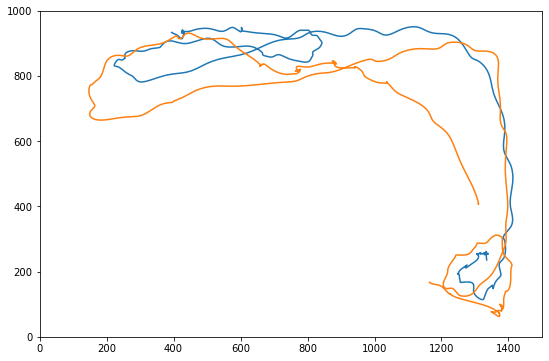

In [17]:
trial_original = all_data['Female1']
trial = trial_original
marker = 'BackCenter'
time = (15000,16000)
xlims = (0,1500)
ylims = (0,1000)
plt.figure(figsize=6*n.array([xlims[1]/ylims[1], 1]))


plt.plot(trial[marker+'_1_x'][time[0]:time[1]],trial[marker+'_1_y'][time[0]:time[1]])
plt.plot(trial[marker+'_2_x'][time[0]:time[1]],trial[marker+'_2_y'][time[0]:time[1]])

plt.xlim(xlims)
plt.ylim(ylims)

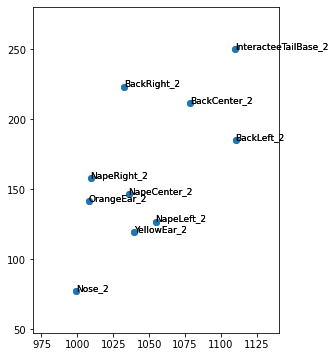

In [18]:

t = 20000
xs = []
ys = []
labs = []
for label in labels:
    mouse_idx = str(2)
    if label[-1] == mouse_idx:
        xs.append(trial[label+'_x'][t])
        ys.append(trial[label+'_y'][t])
        labs.append(label)

xlims = (n.nanmin(xs) - 30, n.nanmax(xs)+30)
ylims = (n.nanmin(ys) - 30, n.nanmax(ys)+30)
plt.figure(figsize=6*n.array([(xlims[1]-xlims[0])/(ylims[1]-ylims[0]), 1]))
        
        
plt.scatter(xs, ys)
for i in range(len(xs)):
    plt.text(xs[i], ys[i], labs[i],fontsize=9)
    
    
plt.xlim(xlims)
plt.ylim(ylims)
plt.show()

## Velocities

In [19]:
trial_with_vectors = trial

In [43]:
names = []; dtypes = []; datas = []
velocities_calculated = []
for label in trial.dtype.names:
    if label[-2:] in ['_x', '_y']:
        names.append(label+'_vel')  
        dtypes += [n.float]
        datas += [n.zeros(trial.shape[0])]
        velocities_calculated.append(label)

In [44]:
trial = rfn.append_fields(trial_original, names, datas, dtypes)
trial = n.array(trial, trial.dtype)

In [48]:
for label in velocities_calculated:
    vel = n.gradient(trial[label])
    trial[label + '_vel'] = vel

## Create architecture

In [112]:
import torch
from torch import nn

In [506]:
trial.shape

(30270,)

In [215]:
# Define data, features & targets
feature_labels = trial.dtype.names[2:]
target_label = trial.dtype.names[1]
data = trial

# Preprocess and format the data
categories = n.unique(data[target_label])
N_categories = len(categories)
cat_to_int = {}
i = 0
for c in categories: 
    cat_to_int[c] = i
    i += 1
targets = (torch.tensor(n.array([cat_to_int[s] for s in data[target_label]]), dtype=torch.long))
# targets_onehot = nn.functional.one_hot(targets)
features = n.zeros((data.shape[0], len(feature_labels)))
for i,fl in enumerat~e(feature_labels):
    features[:,i] = data[fl]
    
# we don't actually care about where in the cage they are, so just make everything referenced to greentape_1 x and y
ref_x = features[:,1].copy()
ref_y = features[:,0].copy()

for i,label in enumerate(feature_labels):
    if label[-1] == 'y':
#         print('y-pre:',n.nanmax(features[:,i]))
        features[:,i] -= ref_y
#         print('y-post:', n.nanmax(features[:,i]))
    elif label[-1] == 'x':
#         print('x-pre:',n.nanmax(features[:,i]))
        features[:,i] -= ref_x
#         print('x-post:', n.nanmax(features[:,i]))
fmin = n.nanmin(features, axis=0)
fmax = n.nanmax(features,axis=0)
# features = (features - fmin)/(fmax-fmin)
features = n.nan_to_num(features, nan=-1)
features = torch.tensor(features).float()

In [429]:
# test and train sets

features_train = features[10000:20000]
features_test = features[20000:25000]
targets_train = targets[10000:20000]
targets_test = targets[20000:25000]

In [457]:

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N_batch = 16
D_in = features.shape[1] 
D_out = N_categories
hidden_dims = [300,300,300]


layers = []
prev_dim = D_in
for dim in hidden_dims:
    layers += [torch.nn.Linear(prev_dim, dim),
               torch.nn.ReLU()]
    prev_dim = dim
layers += [torch.nn.Linear(prev_dim, D_out)]

loss_fn = torch.nn.CrossEntropyLoss()

In [458]:
trackers = {'test_loss' : [], 't' : [], 'train_loss' : [], 'test_frac_correct': []}
best_model = None
def track():
    for key in trackers.keys():
        trackers[key].append(globals()[key])

model = nn.Sequential(*layers)
learning_rate = 1e-4
print_interval = 50


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
t = 0
end = False
for epoch_idx in range(10):
    print("### EPOCH {:2d} ###".format(epoch_idx))
    indices = n.random.choice(range(targets_train.shape[0]), targets_train.shape[0], False)
    num_batches = len(indices) // N_batch + 1
    for batch_idx in range(num_batches):
        batch_train_x = features_train[indices[batch_idx*N_batch :(batch_idx+1)*N_batch]]
        batch_train_y = targets_train[indices[batch_idx*N_batch : (batch_idx+1)*N_batch]]
        # Forward pass: compute predicted y by passing x to the model.
        batch_train_y_pred = model(batch_train_x)

        # Compute and print loss.
        loss = loss_fn(batch_train_y_pred, batch_train_y)
        if batch_idx % print_interval == 0:
            prediction_test = model(features_test)
            train_loss = loss.item()
            test_loss= loss_fn(prediction_test, targets_test).item()
            
            
            pred_labels = n.argmax(prediction_test.detach().numpy(),axis=1)
            true_labels = targets_test.detach().numpy()
            correct_preds = n.array(pred_labels == true_labels, n.int)
            test_frac_correct = n.mean(correct_preds)
            
            if len(trackers['test_loss']) == 0 or test_loss < min(trackers['test_loss']):
                best_model = copy.deepcopy(model)
            print("Batch {:3d}, Train Loss: {:5f}, Test Loss: {:5f}, Test Correct Frac: {:.3f}".format(batch_idx, train_loss, test_loss, test_frac_correct))
            track()
#             if t > print_interval*3 and trackers['test_loss'][-2] < trackers['test_loss'][-1] and \
#                 trackers['test_loss'][-3] < trackers['test_loss'][-2]:
#                 print("End training")
#                 end = True
#                 break
        t += 1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if end: break

### EPOCH  0 ###
Batch   0, Train Loss: 5.329937, Test Loss: 3.944282, Test Correct Frac: 0.091
Batch  50, Train Loss: 0.608119, Test Loss: 1.804965, Test Correct Frac: 0.503
Batch 100, Train Loss: 0.382960, Test Loss: 1.483175, Test Correct Frac: 0.515
Batch 150, Train Loss: 0.289450, Test Loss: 1.561480, Test Correct Frac: 0.509
Batch 200, Train Loss: 0.646475, Test Loss: 1.227701, Test Correct Frac: 0.623
Batch 250, Train Loss: 0.227428, Test Loss: 1.601482, Test Correct Frac: 0.544
Batch 300, Train Loss: 0.314160, Test Loss: 1.397023, Test Correct Frac: 0.614
Batch 350, Train Loss: 0.186951, Test Loss: 1.276588, Test Correct Frac: 0.660
Batch 400, Train Loss: 0.105130, Test Loss: 1.147131, Test Correct Frac: 0.685
Batch 450, Train Loss: 0.187285, Test Loss: 1.271944, Test Correct Frac: 0.637
Batch 500, Train Loss: 0.081484, Test Loss: 1.333535, Test Correct Frac: 0.606
Batch 550, Train Loss: 0.358387, Test Loss: 1.451721, Test Correct Frac: 0.635
Batch 600, Train Loss: 0.318702, Te

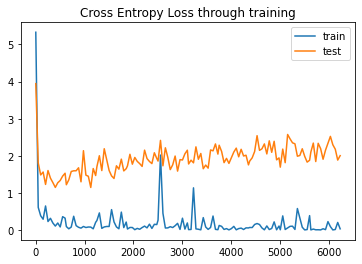

In [462]:
plt.plot(trackers['t'],trackers['train_loss'], label='train')
plt.plot(trackers['t'],trackers['test_loss'], label='test')
plt.title("Cross Entropy Loss through training")
plt.legend()

Text(0.5, 1.0, 'Fraction of correct labels on test set through training')

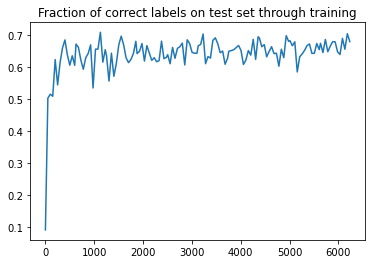

In [463]:
plt.plot(trackers['t'], trackers['test_frac_correct'])
plt.title("Fraction of correct labels on test set through training")

In [433]:
prediction_test = best_model(features_test)

pred = n.argmax(prediction_test.detach().numpy(),axis=1)

true = targets_test.detach().numpy()

In [478]:
confmat = confusion_matrix(true, pred, normalize='true')

In [483]:
n.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [484]:
print(confmat)

[[0.000 0.810 0.000 0.000 0.000 0.060 0.000 0.131]
 [0.000 0.276 0.024 0.000 0.000 0.569 0.000 0.130]
 [0.000 0.001 0.323 0.001 0.016 0.603 0.045 0.010]
 [0.000 0.000 0.280 0.000 0.000 0.600 0.000 0.120]
 [0.000 0.000 0.567 0.000 0.383 0.033 0.000 0.017]
 [0.000 0.067 0.040 0.000 0.001 0.889 0.000 0.003]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.024 0.187 0.045 0.000 0.016 0.278 0.000 0.450]]


In [498]:
categories

array(['Approach', 'Following', 'broadly-Social', 'conspecific-contact',
       'head-to-head', 'head-to-tail', 'nan', 'no-contact'], dtype='<U30')

In [501]:
list(range(len(categories)))

[0, 1, 2, 3, 4, 5, 6, 7]

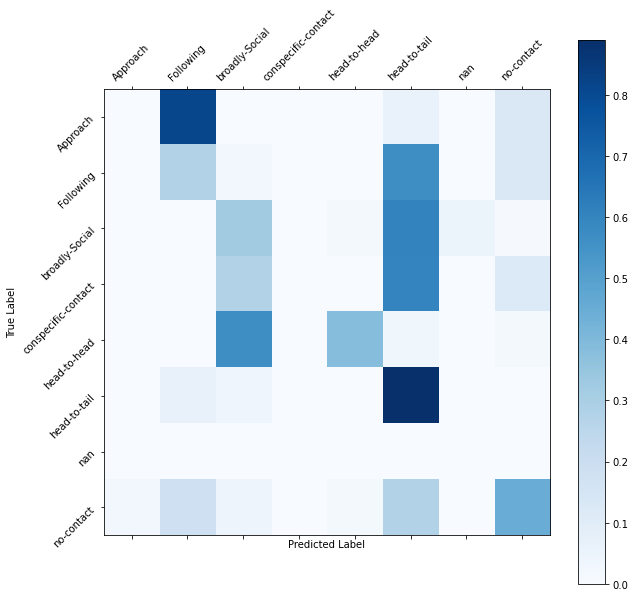

In [505]:
f, ax = plt.subplots(figsize=(10,10))
m = ax.matshow(confmat, cmap='Blues')
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_xticks(list(range(len(categories))))
ax.set_xticklabels(categories, rotation=45)
ax.set_yticks(list(range(len(categories))))
ax.set_yticklabels(categories, rotation=45)
f.colorbar(m)

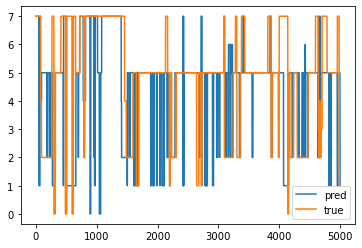

In [446]:
plt.plot(pred, label='pred')
plt.plot(true, label='true')
plt.legend()

Text(0.5, 1.0, 'Label is correct 0.62 of the time')

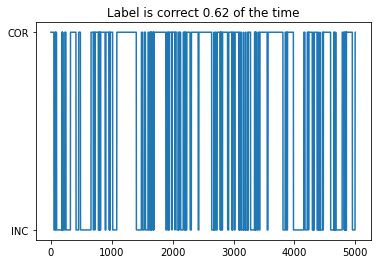

In [451]:
correct_preds = n.array(pred == true, dtype=int)
plt.plot(correct_preds)
plt.yticks([0,1], ['INC', 'COR'])
plt.title("Label is correct {:.2f} of the time".format(n.mean(correct_preds)))

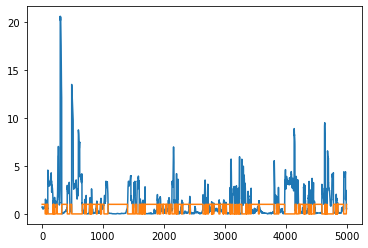

In [448]:

plt.plot([loss_fn(prediction_test[i:i+1],targets_test[i:i+1]).item() for i in range(len(pred))])
